In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
filepath = r"C:\Users\yashp\English to Marathi Translation Using LSTM\eng_mar.csv"
df = pd.read_csv(filepath)
print(df.head(10))  # Check initial data
print(df.columns)   # Verify column names


   Unnamed: 0 English Marathi
0           0     Go.     जा.
1           1     Go.     जा.
2           2     Go.     जा.
3           3     Go.     जा.
4           4     Hi.    हाय.
5           5    Run!   धावा!
6           6    Run.   धावा.
7           7    Who?    WHO?
8           8   Fire!     आग!
9           9   Fire!     आग!
Index(['Unnamed: 0', 'English', 'Marathi'], dtype='object')


In [13]:
# Load dataset
'''def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ["English", "Marathi"]
    df.dropna(inplace=True)
    return df'''

def load_data(filepath):
    df = pd.read_csv(filepath)
    df = df[['English', 'Marathi']]
    df.dropna(inplace=True)
    return df

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

def preprocess_data(df):
    df['English'] = df['English'].apply(clean_text)
    df['Marathi'] = df['Marathi'].apply(clean_text)
    return df

def tokenize_text(df):
    eng_tokens = [word_tokenize(sent) for sent in df['English']]
    mr_tokens = [word_tokenize(sent) for sent in df['Marathi']]
    return eng_tokens, mr_tokens

def build_vocab(tokenized_texts):
    vocab = {word for sentence in tokenized_texts for word in sentence}
    vocab = {word: idx + 1 for idx, word in enumerate(vocab)}
    vocab['<PAD>'] = 0
    return vocab

def encode_sentences(sentences, vocab, max_len):
    encoded = [[vocab.get(word, 0) for word in sent] for sent in sentences]
    padded = [sent + [0] * (max_len - len(sent)) if len(sent) < max_len else sent[:max_len] for sent in encoded]
    return np.array(padded)

class TranslationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMTranslator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMTranslator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 due to bidirectionality
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x


# Load and process data
filepath = r"C:\Users\yashp\English to Marathi Translation Using LSTM\eng_mar.csv"
df = load_data(filepath)
df = preprocess_data(df)
eng_tokens, mr_tokens = tokenize_text(df)
eng_vocab = build_vocab(eng_tokens)
mr_vocab = build_vocab(mr_tokens)

# Set max sequence length
max_len = 10
X = encode_sentences(eng_tokens, eng_vocab, max_len)
y = encode_sentences(mr_tokens, mr_vocab, max_len)

In [14]:
df.head()

,English,Marathi
0,go,ज
1,go,ज
2,go,ज
3,go,ज
4,hi,हय


In [15]:
df.tail()

,English,Marathi
118959,there are four main causes of alcoholrelated d...,अलकहलसबधत मतयच चर मखय करण आहत कर अपघत कव हसचरम...
118960,there are mothers and fathers who will lie awa...,अस आई आण वडल आहत ज मल झप गलयनतर जग हतल आण त गह...
118961,a carbon footprint is the amount of carbon dio...,करबन फटपरट महणज करबन डयऑकसइड परदषणच परमण ज आपण...
118962,since there are usually multiple websites on a...,कणतयह दललय वषयवर सहस अनक वबसइटस असलयन पपअप जहर...
118963,if you want to sound like a native speaker you...,जर तमहल मळ सपकरसरख आवज दययच असल तर तमह तच वकय ...


In [16]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [17]:
# Prepare DataLoader
train_dataset = TranslationDataset(X_train, y_train)
val_dataset = TranslationDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTranslator(len(eng_vocab), 128, 512, len(mr_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}") # Get the name of the CUDA device
else:
    print("Using CPU")

print(f"Device type: {device.type}") # Print the type of device

Using CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Device type: cuda


In [27]:
'''# Training Loop
epochs = 40
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")'''

'# Training Loop\nepochs = 40\ntrain_losses, val_losses = [], []\nfor epoch in range(epochs):\n    model.train()\n    total_loss = 0\n    for X_batch, y_batch in train_loader:\n        X_batch, y_batch = X_batch.to(device), y_batch.to(device)\n        optimizer.zero_grad()\n        output = model(X_batch)\n        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n    train_losses.append(total_loss / len(train_loader))\n    \n    model.eval()\n    val_loss = 0\n    with torch.no_grad():\n        for X_batch, y_batch in val_loader:\n            X_batch, y_batch = X_batch.to(device), y_batch.to(device)\n            output = model(X_batch)\n            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))\n            val_loss += loss.item()\n    val_losses.append(val_loss / len(val_loader))\n    \n    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Lo

In [20]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 30
train_losses, val_losses = [], []
best_val_loss = float("inf")
patience, patience_counter = 5, 0
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    scheduler.step(val_losses[-1])  # Adjust learning rate
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    # Early Stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "best_translator_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 2.6083, Val Loss: 2.0231
Epoch 2, Train Loss: 1.4758, Val Loss: 1.7934
Epoch 3, Train Loss: 0.9589, Val Loss: 1.7852
Epoch 4, Train Loss: 0.6941, Val Loss: 1.8282
Epoch 5, Train Loss: 0.5115, Val Loss: 1.8882
Epoch 6, Train Loss: 0.3747, Val Loss: 1.9699
Epoch 7, Train Loss: 0.2036, Val Loss: 1.9831
Epoch 8, Train Loss: 0.1079, Val Loss: 2.0704
Early stopping triggered.


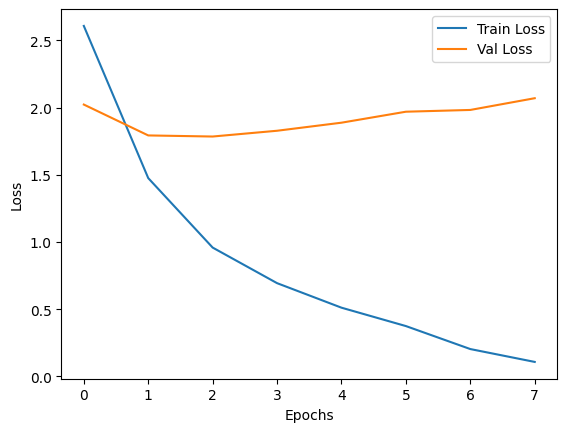

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save Model and Files
torch.save(model.state_dict(), "translator_model_English_to_Marathi.pth")
pd.to_pickle(engM_vocab, "engM_vocab.pkl")
pd.to_pickle(mr_vocab, "mr_vocab.pkl")


In [26]:
torch.save(model.state_dict(), "translator_model_English_to_Marathi.pth")
pickle.dump(eng_vocab, open("eng_vocab.pkl", "wb"))
pickle.dump(mr_vocab, open("mr_vocab.pkl", "wb"))


In [24]:
def translate_sentence(model, sentence, eng_vocab, mr_vocab, max_len=10, device="cuda"):
    model.eval()
    tokens = word_tokenize(sentence.lower())
    encoded = [eng_vocab.get(word, 0) for word in tokens]
    padded = encoded + [0] * (max_len - len(encoded)) if len(encoded) < max_len else encoded[:max_len]
    input_tensor = torch.tensor([padded], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
    
    predicted_tokens = output.argmax(2).squeeze().tolist()
    rev_mr_vocab = {idx: word for word, idx in mr_vocab.items()}
    translated_sentence = " ".join([rev_mr_vocab.get(idx, "") for idx in predicted_tokens])

    return translated_sentence


In [25]:

# Example usage
loaded_model = LSTMTranslator(len(eng_vocab), 128, 512, len(mr_vocab)).to(device)
loaded_model.load_state_dict(torch.load("translator_model_English_to_Marathi.pth"))
loaded_model.eval()

example_sentence = "how are you"
predicted_translation = translate_sentence(loaded_model, example_sentence, eng_vocab, mr_vocab, device=device)
print(f"Translation: {predicted_translation}")

Translation: त कस आहस <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
